In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

# Прогружаем данные

In [3]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1
    df = df.resample("1d").mean()
    df.fillna(method="ffill", inplace=True)

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.adjclose.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=9);
    plt.yscale('log')

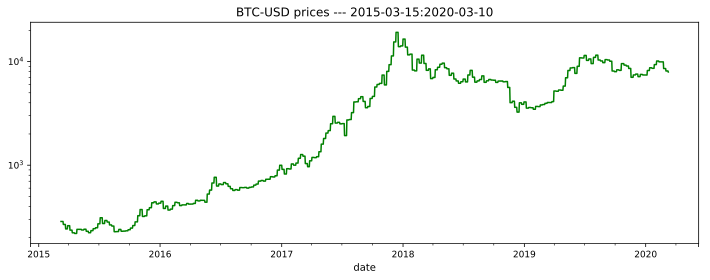

In [39]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-03-15', 
                  end_date='2020-03-10', 
                  freq='weekly', 
                  path='data/BTC.csv')

In [40]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC']

In [41]:
# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    del data[tiker]['open']
    print(data[tiker].head())
        
COLUMNS = ['open', 'close']

                 close
date                  
2015-03-09  286.393005
2015-03-10  286.393005
2015-03-11  286.393005
2015-03-12  286.393005
2015-03-13  286.393005


# Взаимная корреляция

In [62]:
trend = pd.read_csv('data/trends.csv', sep=";", index_col = 'date')

In [63]:
trend.head()

,value
date,
2015-03-15,2
2015-03-22,2
2015-03-29,2
2015-04-05,2
2015-04-12,2


In [64]:
trend.tail()

,value
date,
2020-02-09,13
2020-02-16,11
2020-02-23,11
2020-03-01,11
2020-03-08,14


In [65]:
BTC = pd.read_csv('data/BTC.csv', index_col = 'date')

In [66]:
BTC = BTC[6:len(BTC):7]

In [67]:
BTC.head()

,open,high,low,close,adjclose,volume,dividend,split
date,,,,,,,,
2015-03-15,281.424988,286.528992,280.996002,286.393005,286.393005,11970100.0,0.0,1.0
2015-03-22,285.684998,294.112000,248.636002,267.959991,267.959991,206778200.0,0.0,1.0
2015-03-29,242.878998,260.674988,239.214005,260.597992,260.597992,150120700.0,0.0,1.0
2015-04-05,260.721008,261.798004,232.770996,236.153000,236.153000,147866600.0,0.0,1.0
2015-04-12,235.949997,236.934998,216.322998,222.600006,222.600006,158658500.0,0.0,1.0


In [68]:
trend['BTC'] = BTC['close']

In [69]:
trend.head()

,value,BTC
date,,
2015-03-15,2,286.393005
2015-03-22,2,267.959991
2015-03-29,2,260.597992
2015-04-05,2,236.153000
2015-04-12,2,222.600006


In [70]:
trend.corr(method='pearson')

,value,BTC
value,1.000000,0.700317
BTC,0.700317,1.000000


In [71]:
trend.corr(method='kendall')

,value,BTC
value,1.000000,0.718098
BTC,0.718098,1.000000


In [72]:
trend.corr(method='spearman')

,value,BTC
value,1.000000,0.873829
BTC,0.873829,1.000000


In [73]:
trend.corr(method='pearson').values[0][1]

0.7003172061528926

In [56]:
corr_list = []
corr_list.append(trend.corr(method='pearson').values[0][1])

In [58]:
trend.head(10)

,value,BTC
date,,
2015-03-15,2,286.393005
2015-03-22,2,267.959991
2015-03-29,2,260.597992
2015-04-05,2,236.153000
2015-04-12,2,222.600006
2015-04-19,2,219.429993
2015-04-26,2,240.358002
2015-05-03,2,240.296005
2015-05-10,2,236.802002


# Анализ лага корреляции

In [60]:
for shift in tqdm(range(0, 100)):
    trend.BTC = trend.BTC.shift(1)
    trend.dropna()
    corr_list.append(trend.corr(method='pearson').values[0][1])

100%|██████████| 100/100 [00:00<00:00, 591.47it/s]


In [61]:
corr_list

[0.7003172061528926,
 0.6140692546846301,
 0.5768021225061112,
 0.5514925505980299,
 0.5095528594426972,
 0.479597992829125,
 0.4510114954879458,
 0.41201093229500363,
 0.3730640940148486,
 0.342152168595006,
 0.3102729150365648,
 0.28675236931025233,
 0.26796146307361407,
 0.25158064839414096,
 0.2346383791460522,
 0.21888551859645466,
 0.19970681063899084,
 0.17927290153462158,
 0.1620142022285709,
 0.1413876103242338,
 0.1244311384213966,
 0.11340201338958006,
 0.10051156543830653,
 0.09087246606378652,
 0.08590794854175607,
 0.07944444518136924,
 0.07019323329426892,
 0.0635040203487582,
 0.052755360963630454,
 0.043650372490200956,
 0.03919234918508363,
 0.031023792212653136,
 0.02036524194968047,
 0.011867964446678056,
 0.0027777420061932474,
 -0.005389298994920739,
 -0.011072481234834187,
 -0.018525419297257834,
 -0.02548876426830435,
 -0.03347563938499712,
 -0.039998530114175465,
 -0.04360003685617703,
 -0.04683592899000345,
 -0.05064839580471492,
 -0.0533824023345019,
 -0.0566

In [74]:
neg_corr_list = []
for shift in tqdm(range(0, 100)):
    trend.BTC = trend.BTC.shift(-1)
    trend.dropna()
    neg_corr_list.append(trend.corr(method='pearson').values[0][1])

100%|██████████| 100/100 [00:00<00:00, 596.32it/s]


In [75]:
neg_corr_list

[0.7095827075394741,
 0.7217046337441925,
 0.7083401771445388,
 0.6879932745050953,
 0.6791335982873675,
 0.6533506297407108,
 0.6128265649790255,
 0.5866003392498639,
 0.5722947956897683,
 0.5601192783052104,
 0.564008520748194,
 0.5572738071525695,
 0.5413724702230313,
 0.5234287313925883,
 0.5048959489006634,
 0.4999175514054915,
 0.50076361072331,
 0.5034916801444596,
 0.49749572796621155,
 0.484918408802615,
 0.47018678172834943,
 0.4498777562734032,
 0.4373119004637393,
 0.4252638379647151,
 0.410690329724141,
 0.401831424559245,
 0.3941583789327563,
 0.3879840408425395,
 0.38803147950625105,
 0.39038802260503563,
 0.3839882825132419,
 0.37439052191844097,
 0.36330492649648843,
 0.3454396995490604,
 0.3296869469230242,
 0.3196139454001464,
 0.3058280158375512,
 0.2936408262950616,
 0.282816463458201,
 0.27151940973128746,
 0.26322786234421225,
 0.24425322405866723,
 0.228245229763538,
 0.2110160201635467,
 0.1963965417852949,
 0.1865234918495456,
 0.17346155955272177,
 0.15738688

In [76]:
neg_corr_list.reverse()

In [77]:
neg_corr_list

[0.24799616911986688,
 0.2641933116754442,
 0.2713017648866634,
 0.2723792180049475,
 0.2767629630988796,
 0.27318392645641076,
 0.28121381300664594,
 0.297905267907897,
 0.3144559549847039,
 0.32782686343423345,
 0.3358870694911772,
 0.3413593680214727,
 0.3485706893496485,
 0.36308574995554804,
 0.364831106130083,
 0.3723228185968372,
 0.37260008197188493,
 0.37173221475656293,
 0.37710717507336,
 0.37687328738504394,
 0.3699906454178992,
 0.34838968642876206,
 0.3345528394077467,
 0.31305184014232124,
 0.2944111408703928,
 0.2796588002551998,
 0.2550630514723607,
 0.22572985763335654,
 0.19427699016725253,
 0.1701354242209193,
 0.14663278301024452,
 0.12704305864312113,
 0.10975279739986209,
 0.09423465726321711,
 0.08007119076140161,
 0.0686087344738119,
 0.06050741545461539,
 0.05497330699483325,
 0.05032011228828119,
 0.04793526947900696,
 0.04426645677810438,
 0.03738278659087664,
 0.03753521953137054,
 0.039486764262043894,
 0.043291514565150964,
 0.04919916208586861,
 0.055268

In [78]:
final_list = neg_corr_list + corr_list

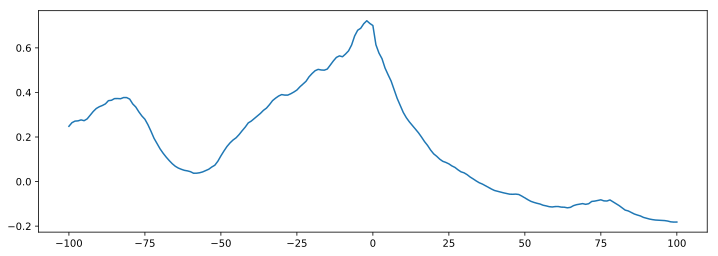

In [79]:
xlist = range(-100, 101)
ylist = final_list
plt.plot(xlist, ylist)
plt.show()

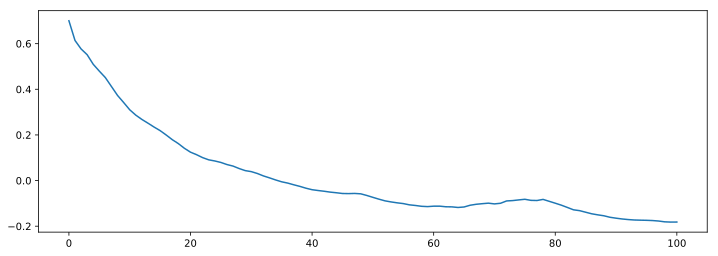

In [80]:
xlist = range(0, 101)
ylist = corr_list
plt.plot(xlist, ylist)
plt.show()